This notebook explores the Gujarat broiler and layer farm dataset from Marie-Cecile Dupas. Dupas et al. (2024) mention that 59% of the farms are associated with village centroids, rather than actual farms. So, after doing some basic stats and narrowing down the dataset to medium and large CAFOs, we visually inspect the areas around the farm coordinates. It turns out that the coordinates bear very little relation to where the farms actually are.

This means that it would be very difficult to associate farms with buildings, characterise the animal housing, and use this dataset for model training. However, it does suggest an area of India where there are many large poultry farms and that could perhaps be a good place to apply the model to see how it does (just via visual examination).

In [4]:
try:
  import unidecode
except ModuleNotFoundError:
  !pip install pyogrio==0.7.2 geopandas==0.14.3 unidecode

In [5]:
%load_ext autoreload
%autoreload 2

import os, sys
from IPython.core.magic import register_cell_magic
from google.colab import drive
import ee
import geemap.foliumap as geemap
import matplotlib.pyplot as plt
import geopandas as gpd
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

@register_cell_magic
def skip(line, cell):
    return

path = "/content/drive/MyDrive/CAFO_data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
gdf1 = gpd.read_file(f'{path}India/Gujarat_broilers.shp').to_crs("EPSG:4326")
gdf2 = gpd.read_file(f'{path}India/Gujarat_layers.shp').to_crs("EPSG:4326")

In [8]:
# What have we got here?

display(gdf1.head(2))
display(gdf2.head(2))

,Stock,geometry
0,15000.0,POINT (73.92916 23.14182)
1,10000.0,POINT (73.35584 23.19060)


,Stock,geometry
0,30000.0,POINT (72.66649 22.89294)
1,89000.0,POINT (72.37716 22.93431)


In [9]:
# As for the Chile data, we define some thresholds of interest. See the Chile
# notebook for further explanation.

numbers = {"potentially_interesting": 10000, "epa_medium_cafo":32000,\
           "epa_large_cafo":100000}

In [24]:
# Basic info about the datasets

for gdf, name in zip([gdf1, gdf2], ["broilers", "layers"]):

  print(f"\nThere are {len(gdf)} entries in the {name} spreadsheet")

  # All geometries are valid:
  assert gdf.is_valid.value_counts().values[0] == len(gdf)

  x = gdf[gdf['Stock'] == 0]
  print(f"{len(x)} farms report 0 {name}")

  for k, v in numbers.items():
    x = gdf[gdf['Stock'] >= v]
    print(f"There are {len(x)} farms above the '{k}' threshold (>={v} {name})")
    print(f"  - They account for {x['Stock'].sum():.0f} {name}")

  print(f"The largest farm reports {gdf['Stock'].max():.0f} {name}")


There are 2611 entries in the broilers spreadsheet
0 farms report 0 broilers
There are 488 farms above the 'potentially_interesting' threshold (>=10000 broilers)
  - They account for 7533288 broilers
There are 21 farms above the 'epa_medium_cafo' threshold (>=32000 broilers)
  - They account for 954812 broilers
There are 0 farms above the 'epa_large_cafo' threshold (>=100000 broilers)
  - They account for 0 broilers
The largest farm reports 90000 broilers

There are 311 entries in the layers spreadsheet
0 farms report 0 layers
There are 193 farms above the 'potentially_interesting' threshold (>=10000 layers)
  - They account for 7718690 layers
There are 69 farms above the 'epa_medium_cafo' threshold (>=32000 layers)
  - They account for 5543300 layers
There are 17 farms above the 'epa_large_cafo' threshold (>=100000 layers)
  - They account for 2608500 layers
The largest farm reports 300000 layers


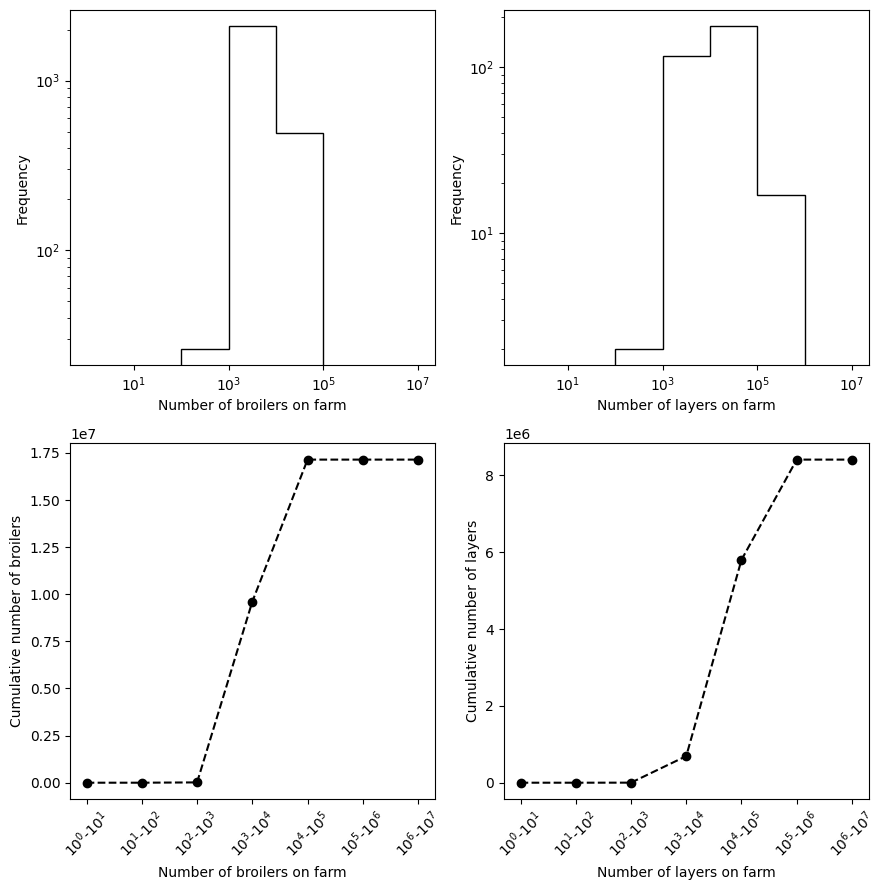

In [ ]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 9))

explore.histo(gdf1, ax1, ax3, 'broilers', 'Stock')
explore.histo(gdf2, ax2, ax4, 'layers', 'Stock')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/CAFO_data/Analysis/Gujarat_histograms.png')

In [31]:
# Filter the data to medium and large CAFOs, and create ee FeatureCollections

def refine(gdf, size_range):
  gdf = gdf[gdf['Stock'] >= size_range["epa_medium_cafo"]]
  fc = geemap.geopandas_to_ee(gdf[["geometry"]])

  return gdf, fc

broilers, broilers_fc = refine(gdf1, numbers)
layers, layers_fc = refine(gdf2, numbers)

In [29]:
# Get the border of Gujarat state

gujarat = gpd.read_file('/content/drive/MyDrive/CAFO_data/India/Gujarat_border.shp')
gujarat_geom = geemap.geopandas_to_ee(gujarat[['geometry']])

In [33]:
Map = geemap.Map()
Map.centerObject(broilers_fc.first().geometry(), 10)

os.environ["HYBRID"] = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'

region_viz = {'color':'red', 'fillColor':'00000000'}

Map.add_basemap("HYBRID")
Map.addLayer(gujarat_geom.style(**region_viz), {}, "")
Map.addLayer(broilers_fc, {'color':'pink', 'width':6}, "Broiler farms")
Map.addLayer(layers_fc, {'color':'cyan', 'width':6}, "Layer farms")


Map

The first two screenshots in the following cell show two locations south of Ahmedabad where there are lots of poultry farms that are not coincident with cyan and pink markers indicating farm coordinates in the Gujarat dataset.

The third screenshot is from near Manekpur in the far south of the state. This appears to be a large poultry farm that doesn't look like a Western-style CAFO.

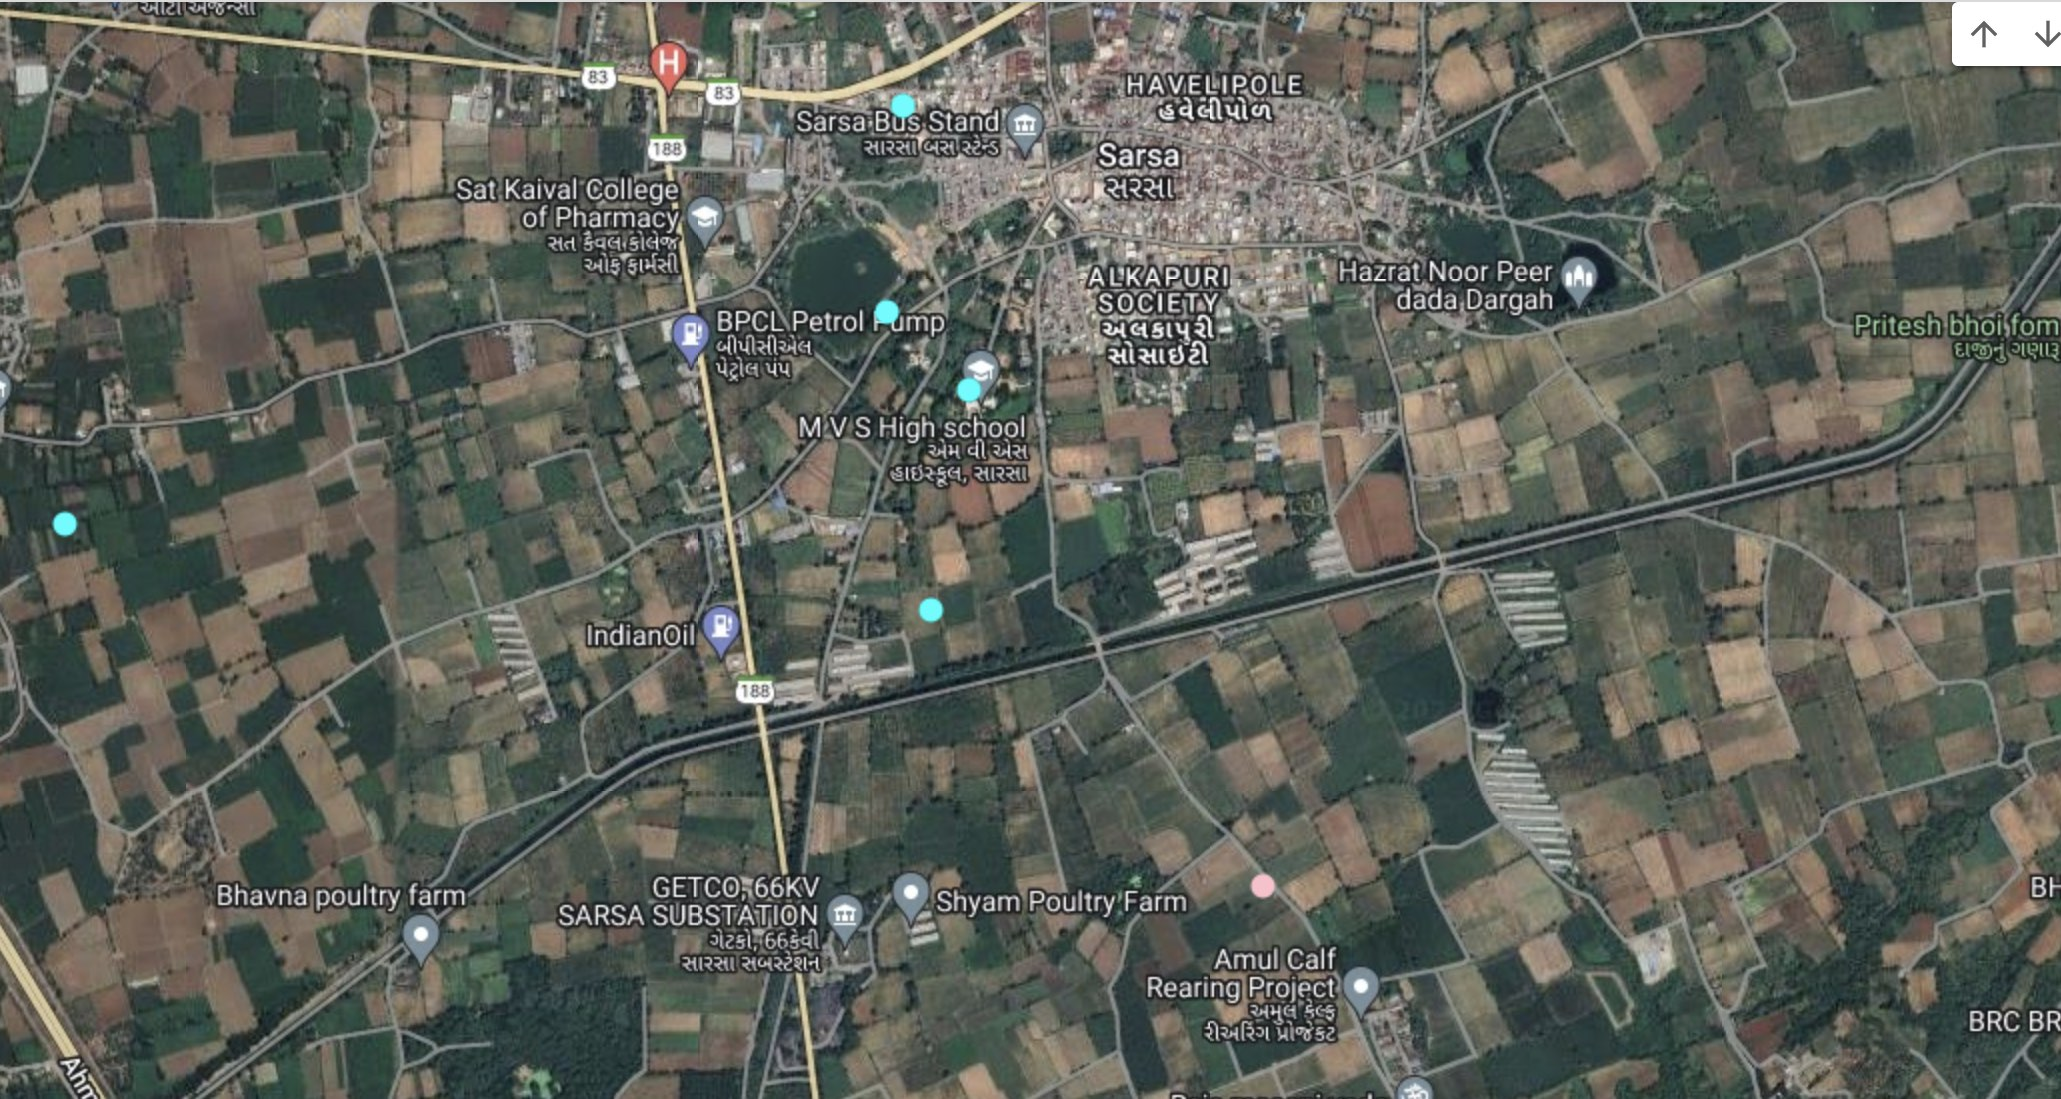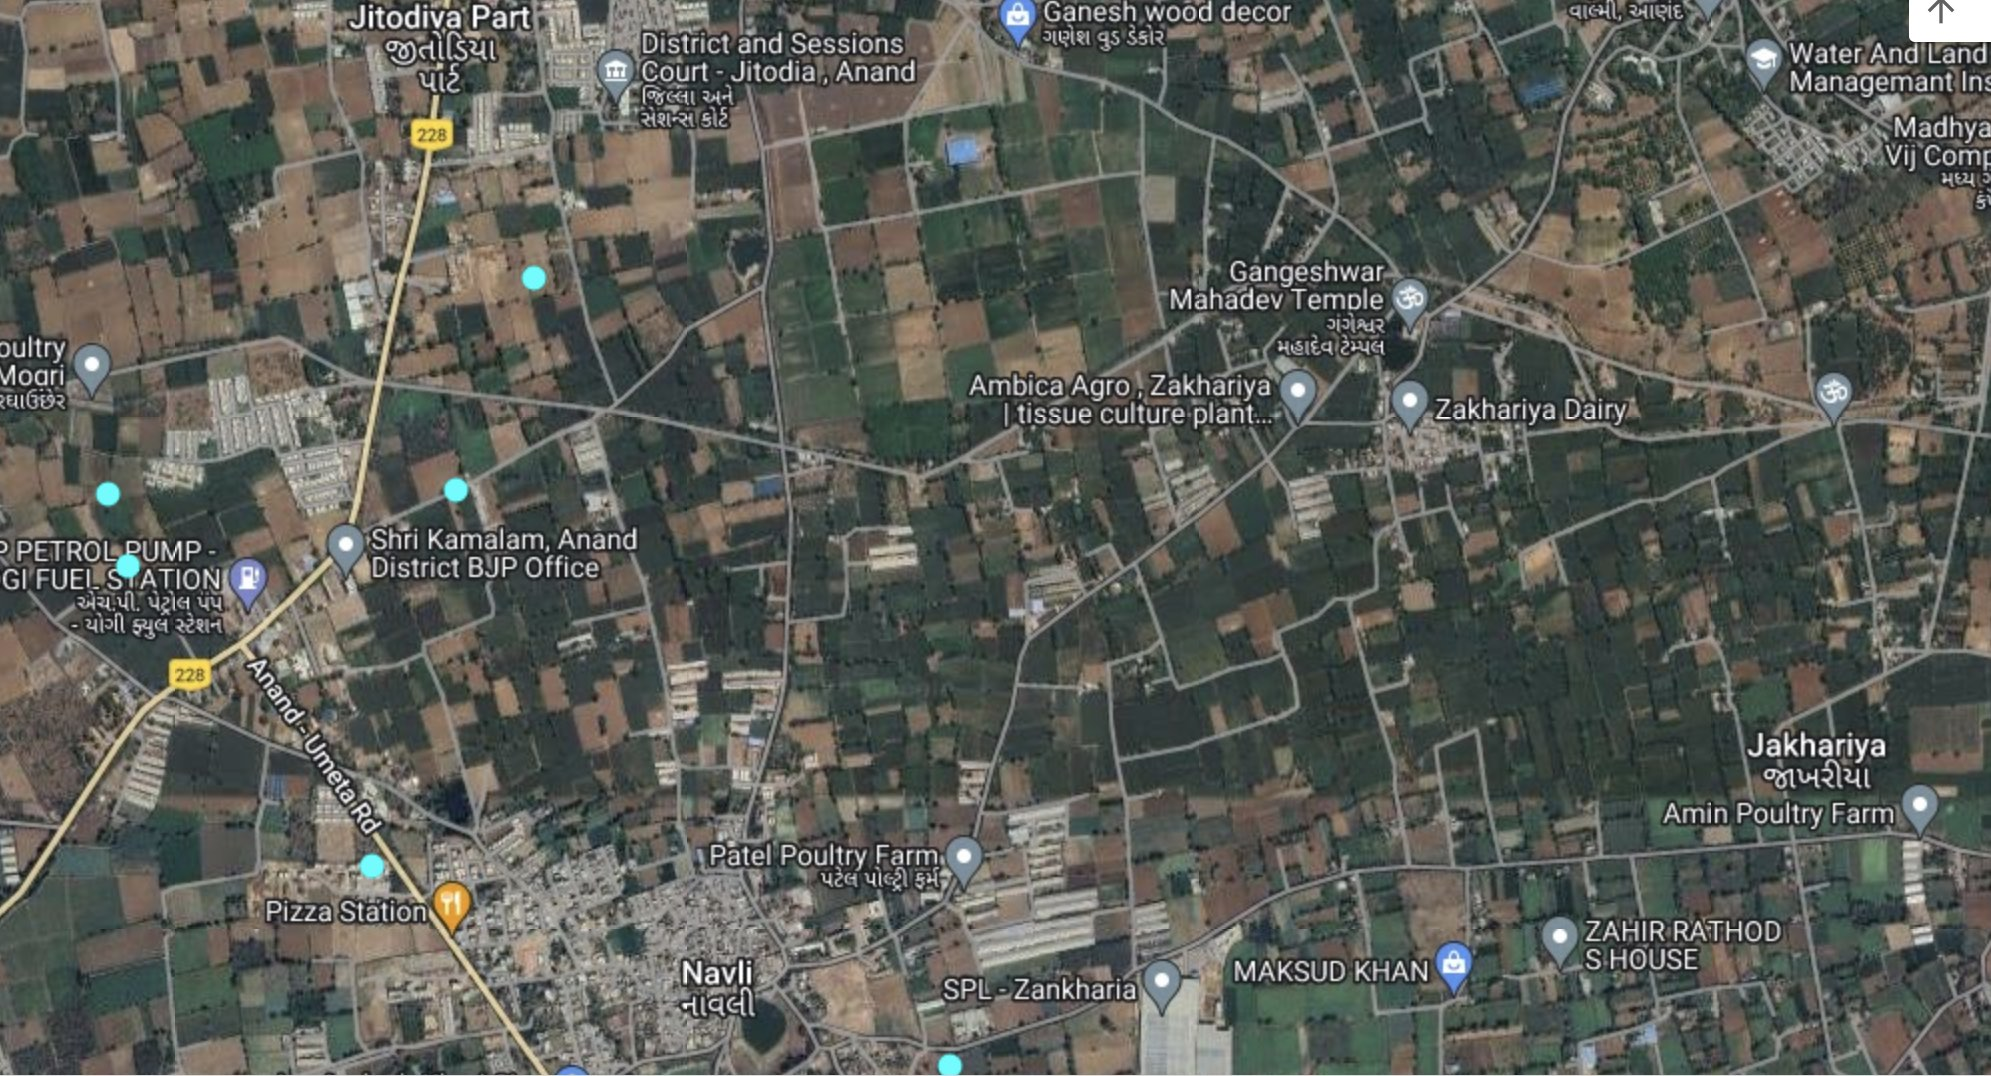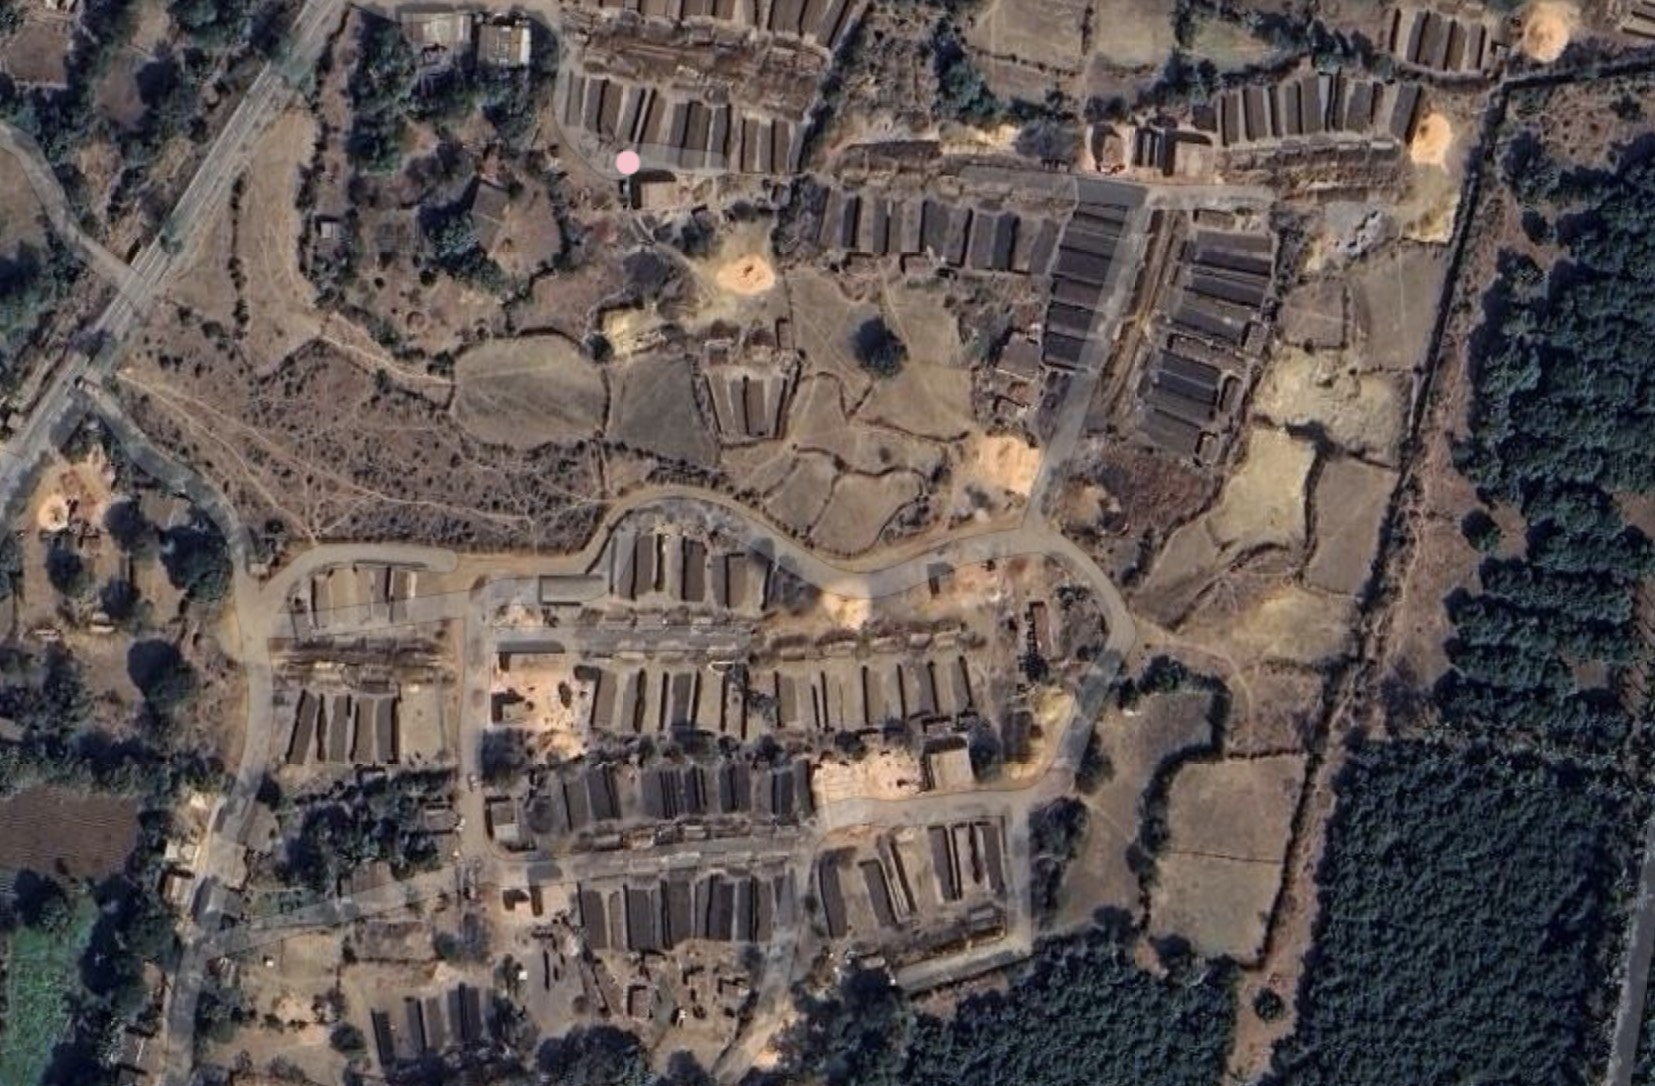